In [1]:
%pylab inline 
import pandas as pd
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')

Populating the interactive namespace from numpy and matplotlib


## Compute Munkres Euclidean score by normalizing by max
$$score = 1-\frac{dist_i}{max(dist)}$$

In [2]:
len(bb_info)

1947

In [3]:
coco_dist = bb_info[bb_info['Munkres Euclidean [COCO]']!=-1]["Munkres Euclidean [COCO]"]
self_dist = bb_info[bb_info['Munkres Euclidean [Self]']!=-1]["Munkres Euclidean [Self]"]

In [4]:
print coco_dist.max()
print self_dist.max()

21899.1693884
24358.4846059


In [5]:
#Normalized Munkres Euclidean = NME
bb_info["NME [COCO]"]= 1-coco_dist/coco_dist.max()
bb_info["NME [Self]"]= 1-self_dist/self_dist.max()

In [6]:
bb_info = bb_info.fillna(-1)#for the -1 flagged item that is filtered out, fill NaN with -1 again

In [7]:
bb_info.to_csv("computed_my_COCO_BBvals.csv")

In [85]:
coco_norm_dist = bb_info[bb_info['NME [COCO]']!=-1]["NME [COCO]"]
self_norm_dist = bb_info[bb_info['NME [Self]']!=-1]["NME [Self]"]

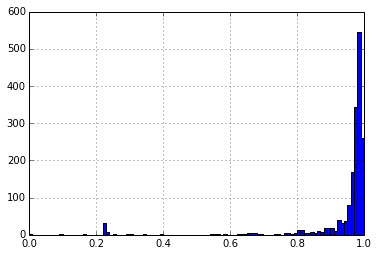

In [86]:
self_norm_dist.hist(bins=100)

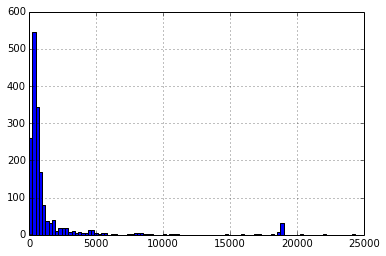

In [87]:
self_dist.hist(bins=100)

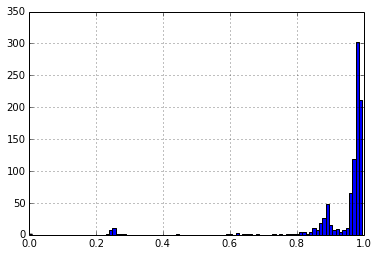

In [88]:
coco_norm_dist.hist(bins=100)

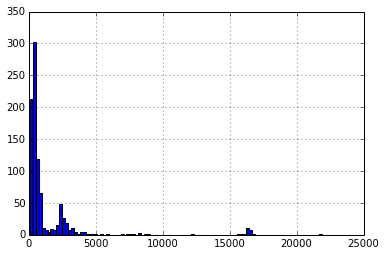

In [89]:
coco_dist.hist(bins=100)

same functional form, just a data transformation.

In [90]:
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [Self]']!=0].sort('object_id')

In [91]:
object_id_lst  = list(set(obj_sorted_tbl.object_id))

In [92]:
from scipy import stats

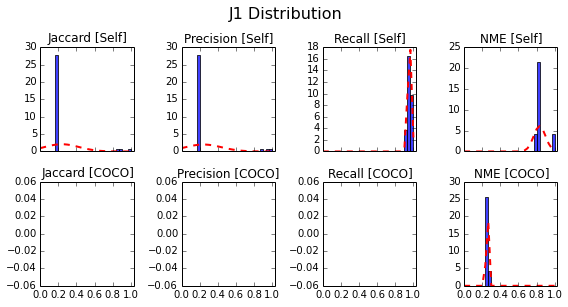

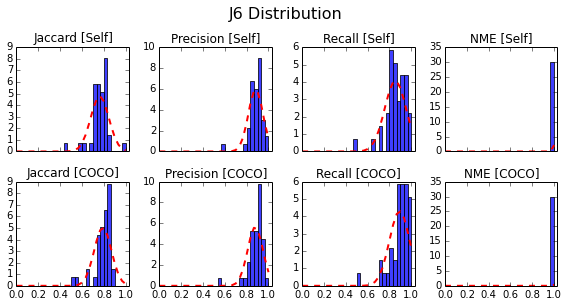

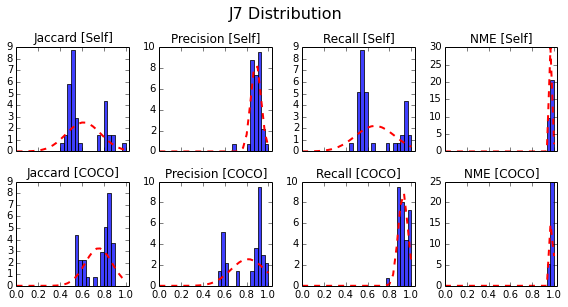

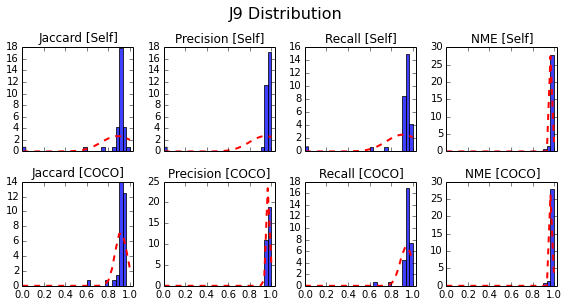

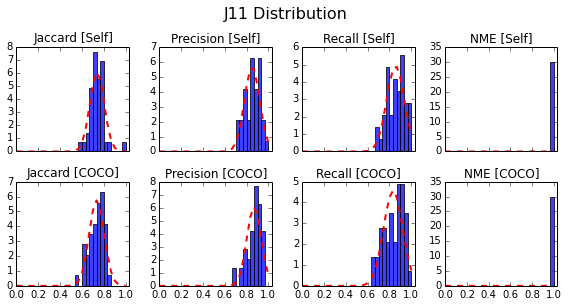

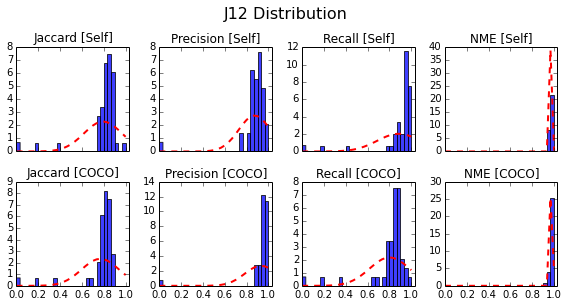

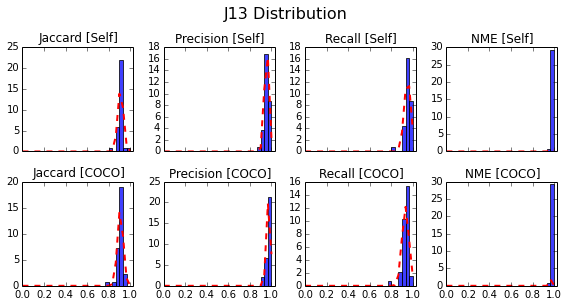

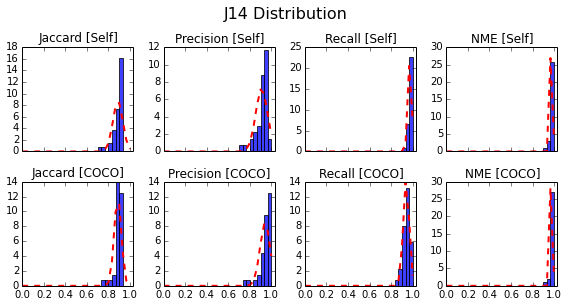

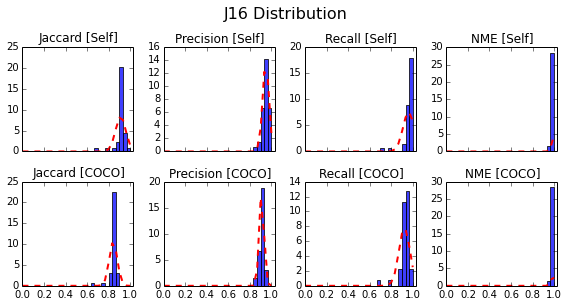

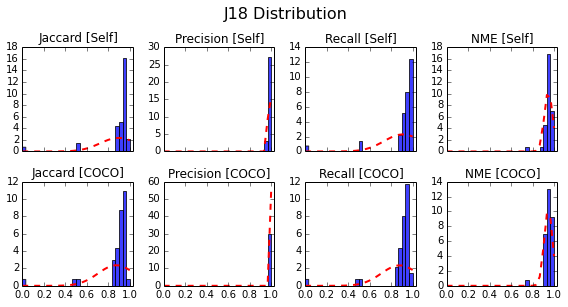

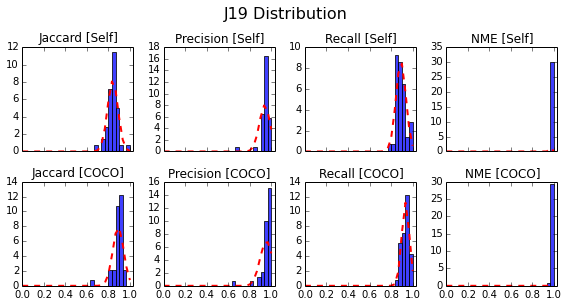

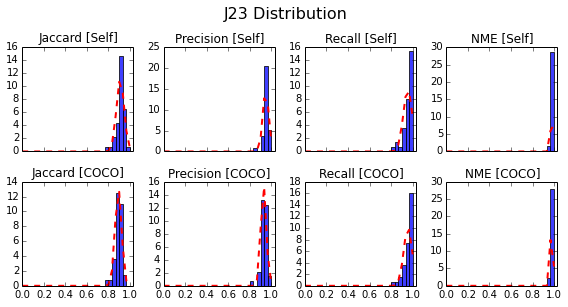

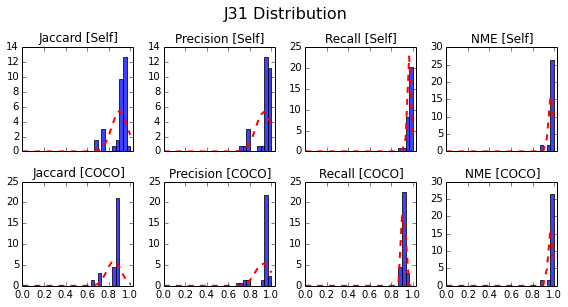

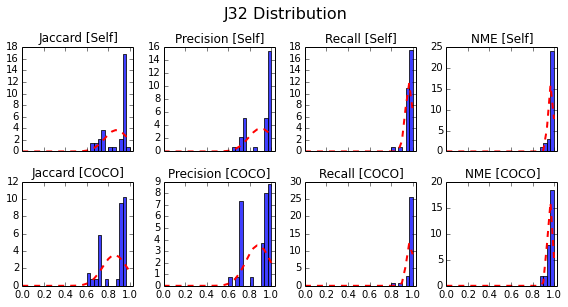

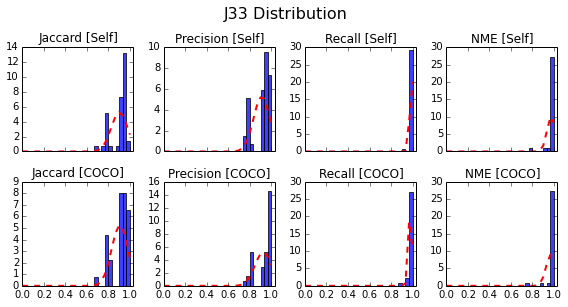

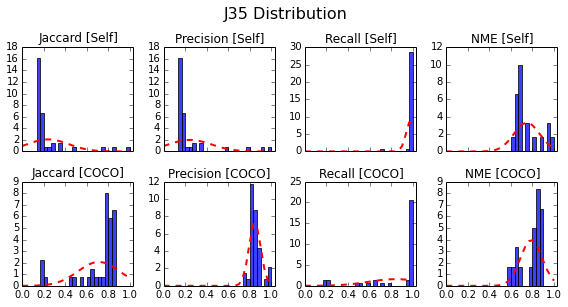

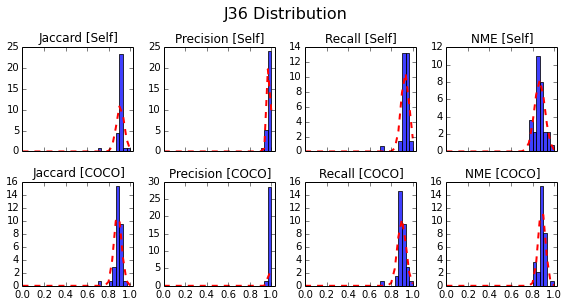

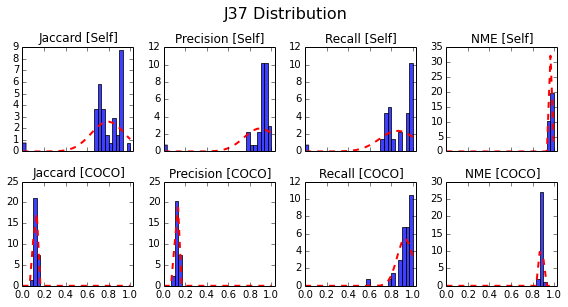

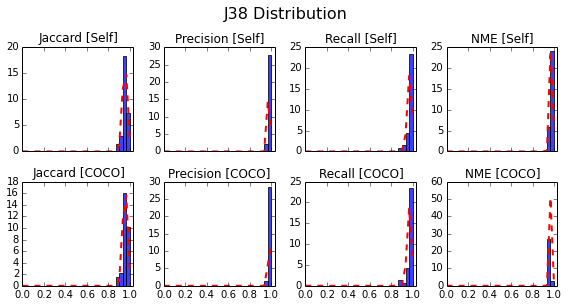

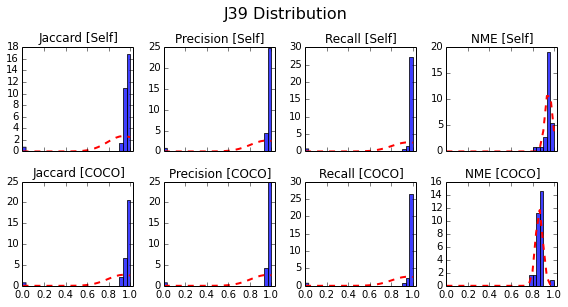

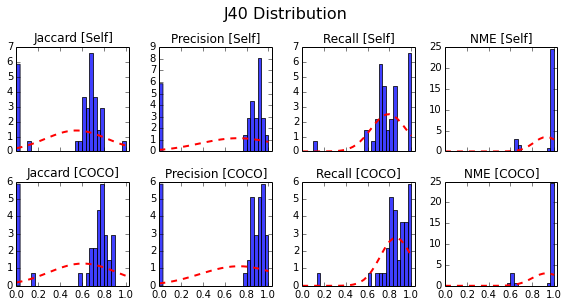

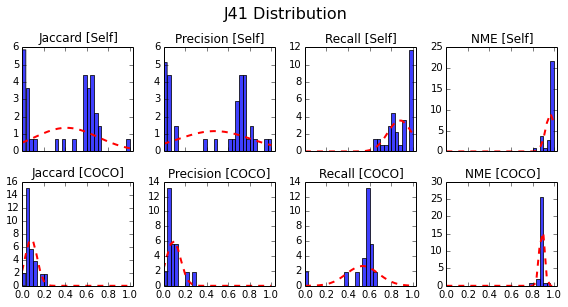

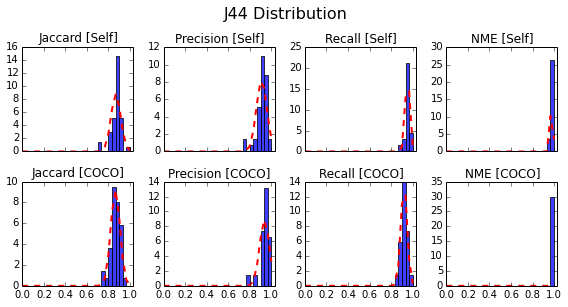

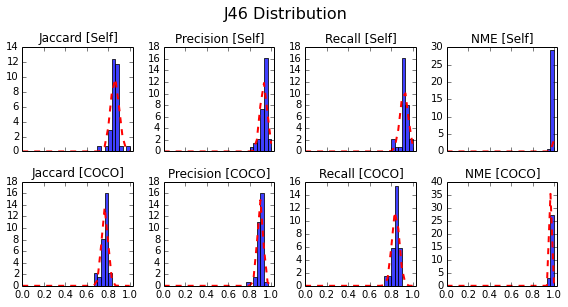

In [97]:
fcn  = stats.norm
# metrics_lst = filter(lambda x: '[' in x,bb_info.columns)
metrics_lst = ['Jaccard [Self]','Precision [Self]','Recall [Self]','NME [Self]',\
               'Jaccard [COCO]','Precision [COCO]','Recall [COCO]','NME [COCO]']
NUM_COL = 4
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW

for objid in object_id_lst:
    fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*4,NUM_COL*1), sharex='col')
    stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
    axs = axs.ravel()
    # Ji is the set of all workers that annotated object i 
    Ji_tbl = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
    bb_info = Ji_tbl
    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        ax = axs[i]
        ax.set_title(metric)
        #ax.hist(metric_value,bins=30)
        ax.set_xlim(0,1.03)

        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        params = fcn.fit(metric_value)
    #     histo,bin_edges = np.histogram(metric_value, 50, normed=1)
    #     bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
        n, bins, patches = ax.hist(metric_value, bins = 30, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
        y = fcn.pdf(bins, *params)
        l = ax.plot(bins, y, 'r--', linewidth=2) 

    fig.tight_layout()
# fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

## RSS and KS test result for fitting norm

Testing other functions is unneccesary since Gaussian is a "good-enough" fit, that would be a simple and interpretable parameterization $\Phi$

In [95]:
from analysis_toolbox import *

In [6]:
fcn  = stats.norm
SHOW_PLOT=False
metrics_lst = ['Jaccard [Self]','Precision [Self]','Recall [Self]','NME [Self]',\
               'Jaccard [COCO]','Precision [COCO]','Recall [COCO]','NME [COCO]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW
data_fit_stats=[]
for objid in object_id_lst:
    if SHOW_PLOT:
        fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
        stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
        axs = axs.ravel()
    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_info  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]

    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
#         table_data.append(basic_stat(metric_value,metric))
        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        params = fcn.fit(metric_value)
        histo,bin_edges = np.histogram(metric_value, 40, normed=1)
        bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
        y = fcn.pdf(bins, *params)
        RSS =sum((histo-y)**2)
        ks_result = kolmogorov_smirnov(bins,y,"Gaussian") #D-value and p-value
        # object_id, Metric, mu, sd,RSS,D-value,p-value
        data_stats  = [objid,metric,params[0],params[1],RSS,ks_result[0],ks_result[1]] 
        #same as what you would get if you did basic_stats because in the MLE estimate, mu and sigma is equal to sample mean and sample sd
        data_fit_stats.append(data_stats)
        if SHOW_PLOT:
            ax = axs[i]
            ax.set_title(metric)
            #ax.hist(metric_value,bins=30)
            ax.set_xlim(0,1.03)
            n, bins, patches = ax.hist(metric_value, 40, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
            y = fcn.pdf(bins, *params)
            l = ax.plot(bins, y, 'r--', linewidth=2) 

    if SHOW_PLOT: fig.tight_layout()
# fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

In [7]:
gaussian_fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Mean", "SD","RSS","D-value","p-value"])

In [8]:
#The fitting is not really statistically significant, average RSS is quite large too 
print gaussian_fit_results.RSS.mean()
gaussian_fit_results[gaussian_fit_results["p-value"]>0.5]

4270.7725604


,object_id,Metric,Mean,SD,RSS,D-value,p-value


In [9]:
gaussian_fit_results

,object_id,Metric,Mean,SD,RSS,D-value,p-value
0,1,Precision [COCO],0.972499,0.021205,7131.800417,0.925,2.887954e-16
1,1,Recall [COCO],0.843183,0.194542,546.841966,0.450,3.565228e-04
2,1,Jaccard [COCO],0.823547,0.189367,587.590150,0.475,1.330354e-04
3,1,Precision [Self],0.244087,0.202222,1771.226787,0.375,4.984225e-03
4,1,Recall [Self],0.957798,0.020984,4362.277369,0.975,5.033001e-18
5,1,Jaccard [Self],0.240031,0.193926,1760.931862,0.400,2.182240e-03
6,6,Precision [COCO],0.878793,0.071300,354.224431,0.550,5.020623e-06
7,6,Recall [COCO],0.890581,0.093161,132.619635,0.550,5.020623e-06
8,6,Jaccard [COCO],0.788697,0.079127,316.550276,0.650,3.014130e-08
9,6,Precision [Self],0.882589,0.067549,182.706039,0.600,4.327560e-07


### Since gaussian isn't great, Try fitting to other functions 

In [6]:
exclude= ['division', 'skellam', 'nbinom', 'logser', 'erlang','dlaplace', 'hypergeom', 'bernoulli', 'levy_stable', 'zipf', 'rv_discrete', 'rv_frozen', 'boltzmann', 'rv_continuous', 'entropy', 'randint', 'poisson', 'geom', 'binom', 'planck', 'print_function']
fcn_lst =  filter(lambda x: x not in exclude,dir(stats.distributions)[9:])

alpha : D = 0.2 ; p =0.77 ---> from same distribution
beta : D = 0.4 ; p =0.06 ---> from same distribution
betaprime : D = 0.4 ; p =0.06 ---> from same distribution
chi : D = 0.4 ; p =0.06 ---> from same distribution
chi2 : D = 0.35 ; p =0.13 ---> from same distribution
dweibull : D = 0.35 ; p =0.13 ---> from same distribution
dweibull : D = 0.35 ; p =0.13 ---> from same distribution
exponpow : D = 0.25 ; p =0.5 ---> from same distribution
exponpow : D = 0.25 ; p =0.5 ---> from same distribution
f : D = 0.4 ; p =0.06 ---> from same distribution
f : D = 0.4 ; p =0.06 ---> from same distribution
fatiguelife : D = 0.4 ; p =0.06 ---> from same distribution
fatiguelife : D = 0.4 ; p =0.06 ---> from same distribution
fatiguelife : D = 0.35 ; p =0.13 ---> from same distribution
fatiguelife : D = 0.4 ; p =0.06 ---> from same distribution
foldnorm : D = 0.35 ; p =0.13 ---> from same distribution
foldnorm : D = 0.35 ; p =0.13 ---> from same distribution
frechet_l : D = 0.35 ; p =0.13 ---> from s

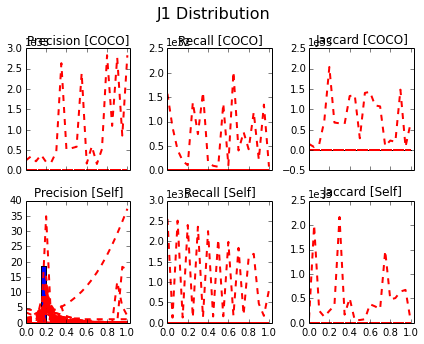

In [29]:
SHOW_PLOT=True
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW
data_fit_stats=[]
i=0
for objid in object_id_lst:
    if i<2:
        if SHOW_PLOT:
            fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
            stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
            axs = axs.ravel()
        # Ji_tbl (bb_info) is the set of all workers that annotated object i 
        bb_info  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
        for fcn_name in fcn_lst:
            fcn = getattr(stats,fcn_name)
            for i,metric in zip(range(len(metrics_lst)),metrics_lst):
        #         table_data.append(basic_stat(metric_value,metric))
                metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
                params = fcn.fit(metric_value)
                histo,bin_edges = np.histogram(metric_value, 20, range=(0,1),normed=1)
                bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
                y = fcn.pdf(bins, *params)
                RSS =sum((histo-y)**2)
                ks_result = kolmogorov_smirnov(bins,y,fcn.name) #D-value and p-value
                # object_id, Metric,Function, mu, sd,RSS,D-value,p-value
                data_stats  = [objid,metric, fcn_name,params[0],params[1],RSS,ks_result[0],ks_result[1]] 
                #same as what you would get if you did basic_stats because in the MLE estimate, mu and sigma is equal to sample mean and sample sd
                data_fit_stats.append(data_stats)
                if SHOW_PLOT:
                    ax = axs[i]
                    ax.set_title(metric)
                    #ax.hist(metric_value,bins=30)
                    ax.set_xlim(0,1.03)
                    n, bins, patches = ax.hist(metric_value, 20, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
                    y = fcn.pdf(bins, *params)
                    l = ax.plot(bins, y, 'r--', linewidth=2) 

            if SHOW_PLOT: fig.tight_layout()
        i+=1
    else:
        break
    # fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

In [14]:
fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Function","Mean", "SD","RSS","D-value","p-value"])

In [17]:
fit_results[fit_results["p-value"]>0.5]

,object_id,Metric,Function,Mean,SD,RSS,D-value,p-value
283,1,Recall [COCO],levy,0.092543,0.476970,653.154746,0.125,0.893086
284,1,Jaccard [COCO],levy,0.093234,0.463932,701.067562,0.125,0.893086


In [16]:
fit_results[fit_results["p-value"]>0.1]

,object_id,Metric,Function,Mean,SD,RSS,D-value,p-value
135,1,Precision [Self],frechet_r,0.510298,0.173717,1191.744568,0.250,0.139252
283,1,Recall [COCO],levy,0.092543,0.476970,653.154746,0.125,0.893086
284,1,Jaccard [COCO],levy,0.093234,0.463932,701.067562,0.125,0.893086
339,1,Precision [Self],nakagami,0.137724,0.173717,1236.206004,0.225,0.230740
341,1,Jaccard [Self],nakagami,0.128941,0.172608,1227.606694,0.250,0.139252
495,1,Precision [Self],weibull_min,0.510298,0.173717,1191.744568,0.250,0.139252


In [27]:
idx = fit_results.groupby(['Metric'])['p-value'].transform(max) ==fit_results["p-value"]
fit_results[idx]

,object_id,Metric,Function,Mean,SD,RSS,D-value,p-value
16,1,Recall [Self],arcsine,0.939805,0.060195,6626.388416,0.625,1.172933e-07
283,1,Recall [COCO],levy,0.092543,0.476970,653.154746,0.125,8.930857e-01
284,1,Jaccard [COCO],levy,0.093234,0.463932,701.067562,0.125,8.930857e-01
339,1,Precision [Self],nakagami,0.137724,0.173717,1236.206004,0.225,2.307405e-01
341,1,Jaccard [Self],nakagami,0.128941,0.172608,1227.606694,0.250,1.392522e-01
384,1,Precision [COCO],powerlognorm,0.000104,0.041269,13503.254665,0.350,1.079322e-02
406,1,Recall [Self],rdist,1.048810,0.957776,7865.993752,0.625,1.172933e-07


If you decrease the bin size, this would fit a lot of function

I think a bin size of 20 is reasonable, this way, even though many function would be matching, gaussian is one of the matching ones, it is more interpretable

In [50]:
len(object_id_lst)*len(metrics_lst)

144

In [62]:
import ast

29.774999999999999

J1Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J1Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J9Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J12Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J12Recall [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J18Recall [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J18Jaccard [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J18Recall [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J18Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J35Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J35Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J37Recall [Self] : D = 0.35 ; p =0.13 ---> from same distribution
J40Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution


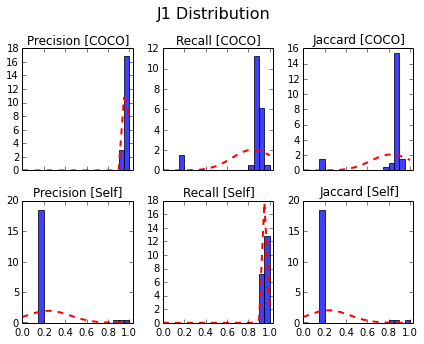

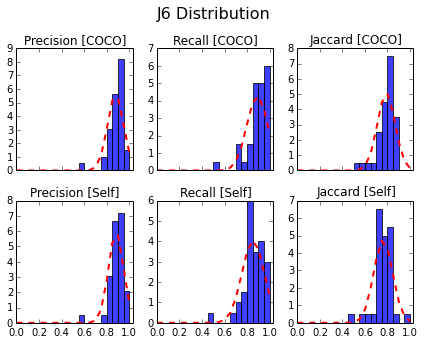

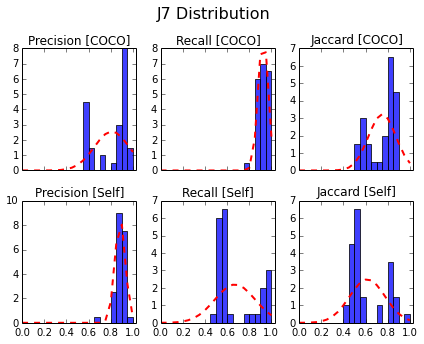

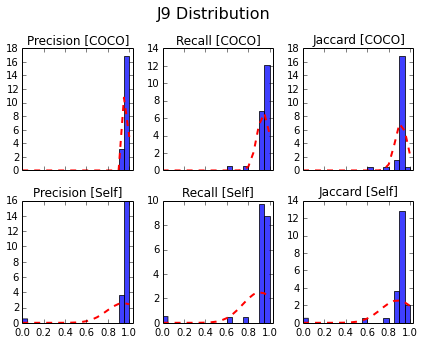

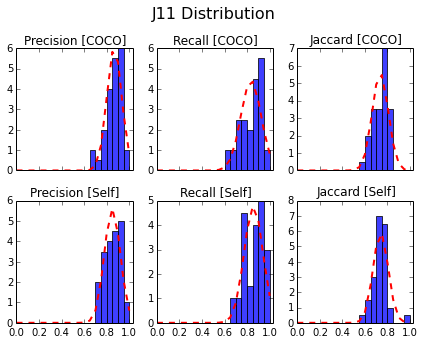

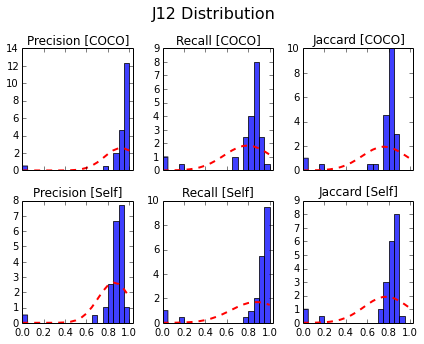

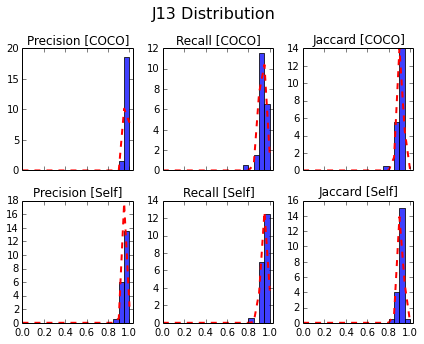

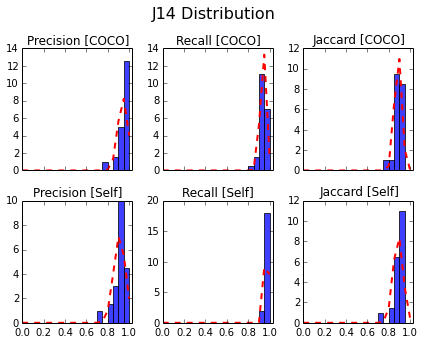

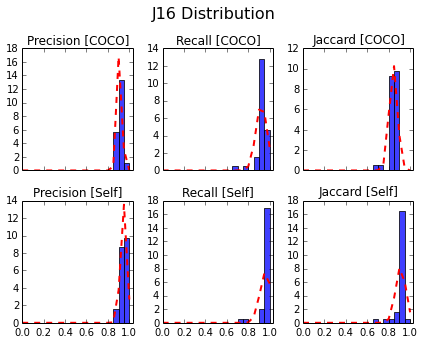

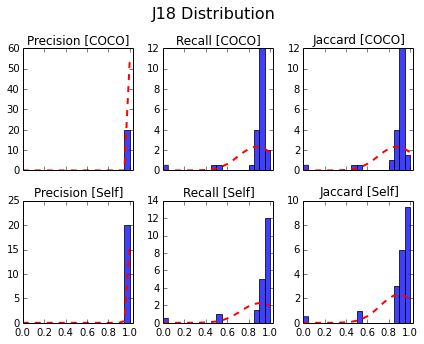

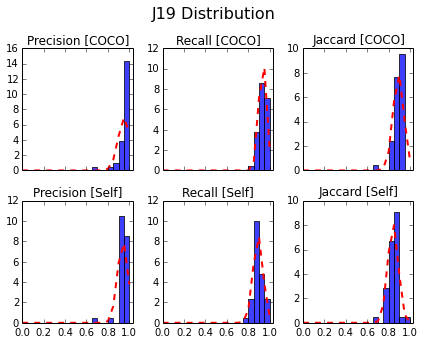

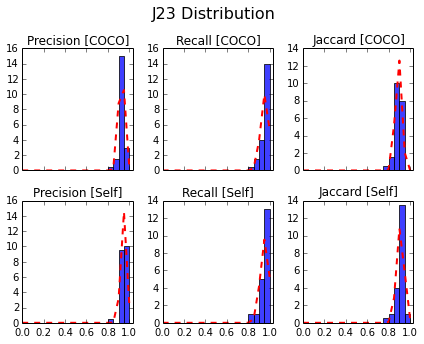

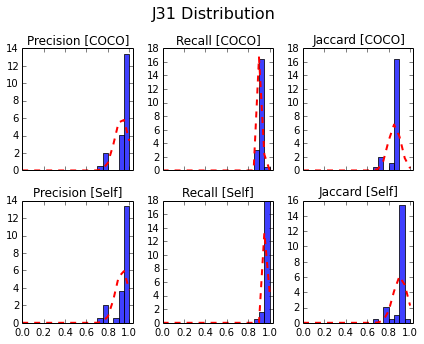

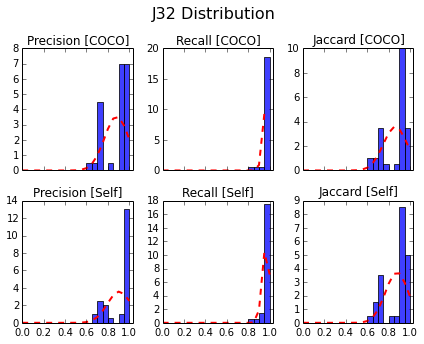

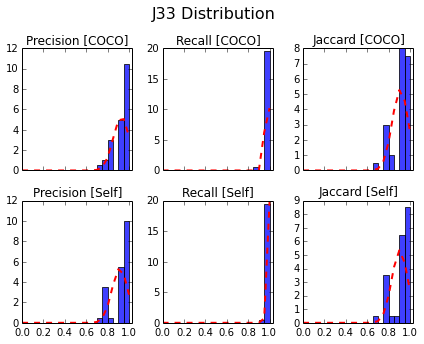

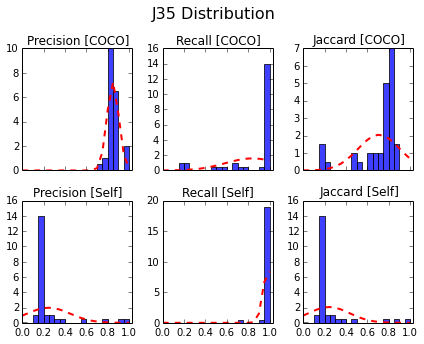

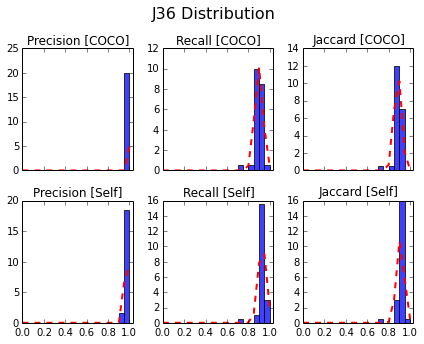

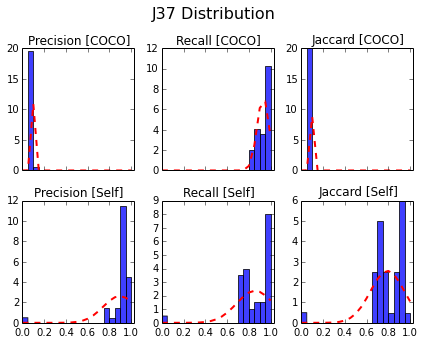

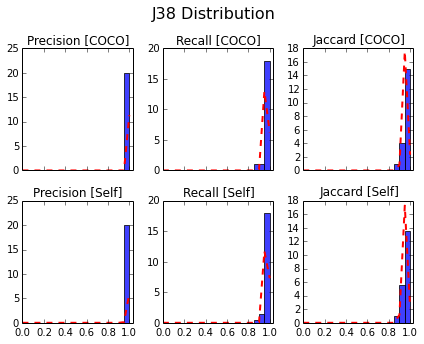

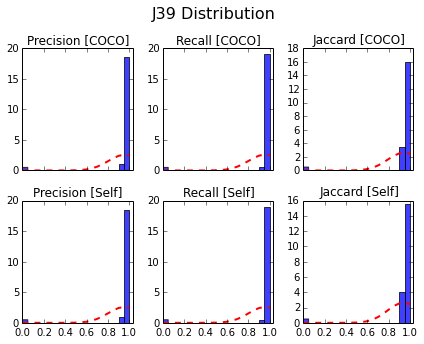

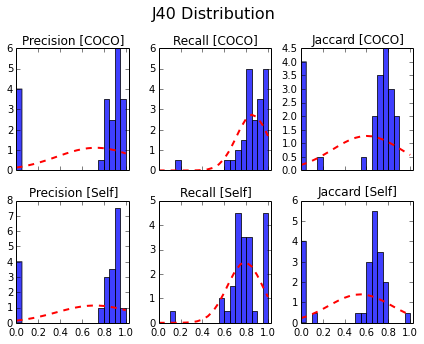

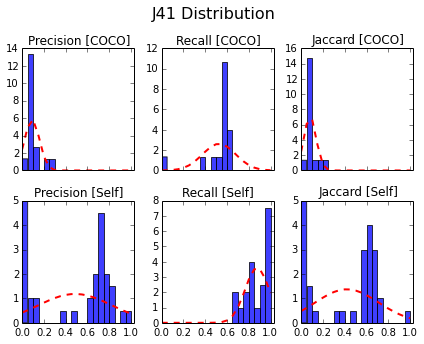

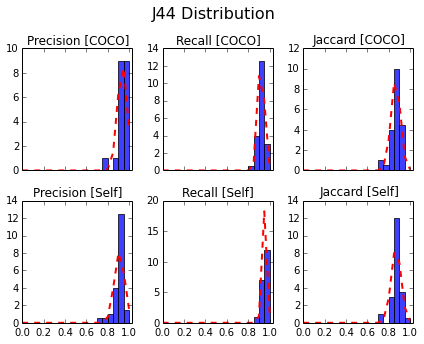

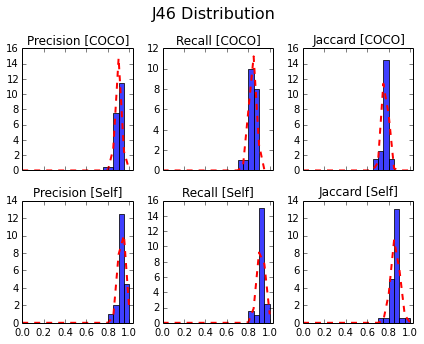

In [68]:
bin_size = 20
fcn  = stats.norm
SHOW_PLOT=True
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW
data_fit_stats=[]
for objid in object_id_lst:
    if SHOW_PLOT:
        fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
        stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
        axs = axs.ravel()
    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_info  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
    numPoints = bb_info["x_locs"].apply(lambda x: len(ast.literal_eval(x))).mean()
    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
#         table_data.append(basic_stat(metric_value,metric))
        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        params = fcn.fit(metric_value)
        histo,bin_edges = np.histogram(metric_value, bin_size, normed=1)
        bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
        y = fcn.pdf(bins, *params)
        RSS =sum((histo-y)**2)
        ks_result = kolmogorov_smirnov(bins,y,"J"+str(objid)+metric) #D-value and p-value
        # object_id, Metric, mu, sd,RSS,D-value,p-value,numPoints
        data_stats  = [objid,metric,params[0],params[1],RSS,ks_result[1],ks_result[0],numPoints] 
        #same as what you would get if you did basic_stats because in the MLE estimate, mu and sigma is equal to sample mean and sample sd
        data_fit_stats.append(data_stats)
        if SHOW_PLOT:
            ax = axs[i]
            ax.set_title(metric)
            #ax.hist(metric_value,bins=30)
            ax.set_xlim(0,1.03)
            n, bins, patches = ax.hist(metric_value, bin_size, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
            y = fcn.pdf(bins, *params)
            l = ax.plot(bins, y, 'r--', linewidth=2) 

    if SHOW_PLOT: fig.tight_layout()
# fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

In [72]:
gaussian_fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Mean", "SD","RSS","D-value","p-value","Average Num Point"])

In [73]:
#The fitting is not really statistically significant, average RSS is quite large too 
print gaussian_fit_results.RSS.mean()

1337.53568157


In [74]:
print len(gaussian_fit_results[gaussian_fit_results["p-value"]>0.5])

102

In [75]:
102/144.

0.7083333333333334

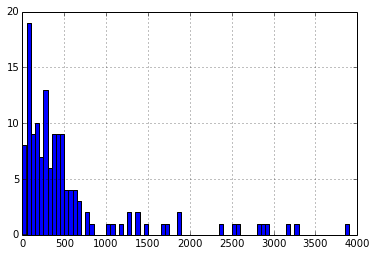

In [76]:
gaussian_fit_results.RSS.hist(bins=100,range=(0,5000))

- perform a linear regression of SD spread of distribution versus the average number of points in the plot (i.e. how hard it is to draw the BB)

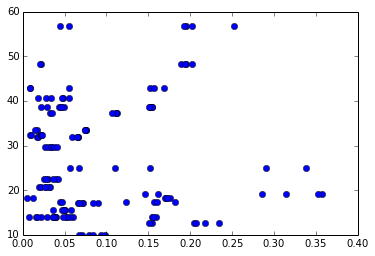

In [79]:
plt.plot(gaussian_fit_results["SD"][gaussian_fit_results["Metric"]],gaussian_fit_results["Average Num Point"],'o')

In [83]:
metrics = list(set(gaussian_fit_results["Metric"]))

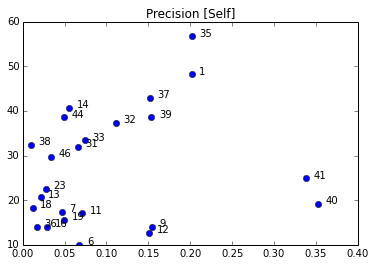

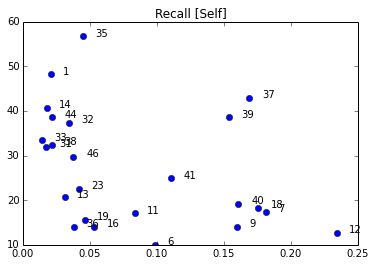

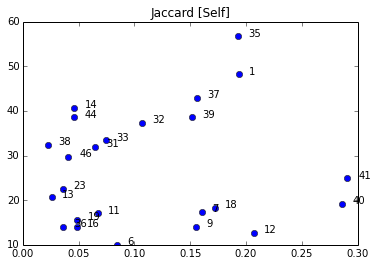

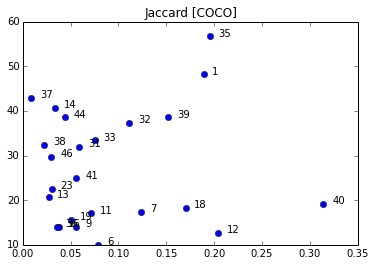

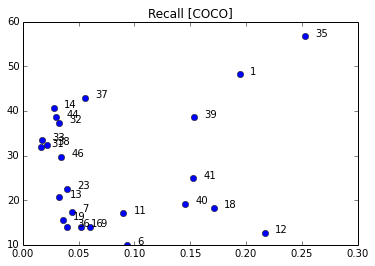

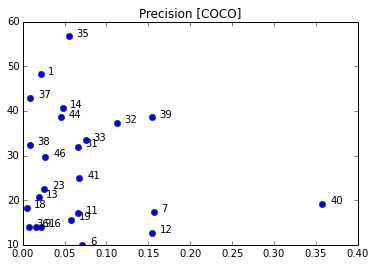

In [121]:
for metric in metrics:
    plt.figure()
    plt.title(metric)
    metric_only_fit_result = gaussian_fit_results[gaussian_fit_results["Metric"]==metric]
    plt.plot(metric_only_fit_result["SD"],metric_only_fit_result["Average Num Point"],'o')
    for row in metric_only_fit_result.iterrows():
        row = row[1]
        plt.text(row["SD"]+0.01,row["Average Num Point"]+0.01,str(row["object_id"]))

When we look at outliers, 
- 40 driver (small,hard to annotate) 
- 41 yellow bannana (task ambiguity)
- 18 monitor, although this is quite a rectangular looking object, there is also quite a few disagreement in the border regions
- 12 knife, very narrow object, hard to annotate
- 35 girl (task ambiguity)

####To do: some objects were not included because it did not have a matching COCO, compute metric and deal with -1 and 0s still plot these in to help with the regression since having all 46 objects would be helpful 

In [154]:
# obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [Self]']!=0].sort('object_id')
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
obj_sorted_tbl =  bb_info.sort('object_id')
object_id_lst  = list(set(obj_sorted_tbl.object_id))

In [155]:
# obj_sorted_tbl[obj_sorted_tbl["Recall [COCO]"]==-1.0]

In [156]:
bb_info[bb_info[metric]==-1]

,Unnamed: 0,object_id,worker_id,x_locs,y_locs,Jaccard [Self],Precision [Self],Recall [Self],Jaccard [COCO],Precision [COCO],Recall [COCO]


J1Recall [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J1Jaccard [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J9Precision [COCO] : D = 0.35 ; p =0.13 ---> from same distribution
J9Recall [COCO] : D = 0.35 ; p =0.13 ---> from same distribution
J9Jaccard [COCO] : D = 0.35 ; p =0.13 ---> from same distribution
J9Precision [Self] : D = 0.35 ; p =0.13 ---> from same distribution
J9Recall [Self] : D = 0.35 ; p =0.13 ---> from same distribution
J9Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J12Recall [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J15Precision [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J17Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J18Recall [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J18Jaccard [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J18Recall [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J18Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J20Precisio

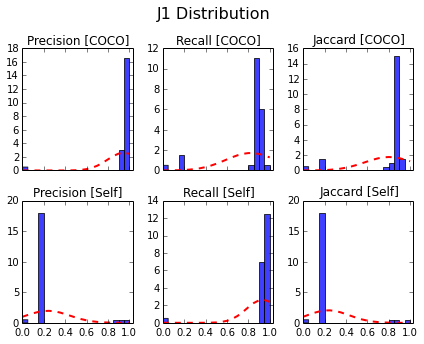

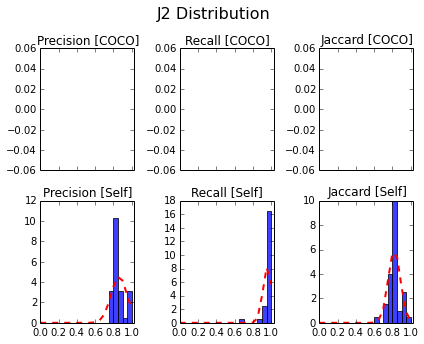

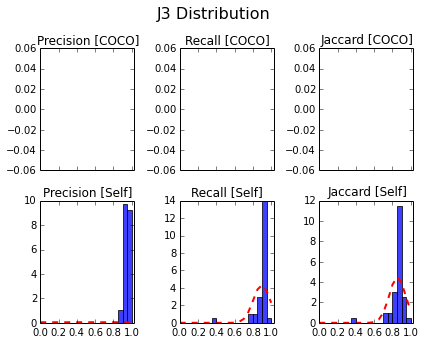

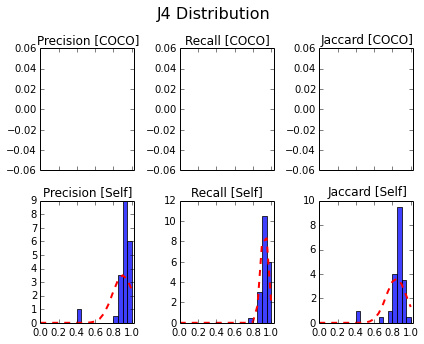

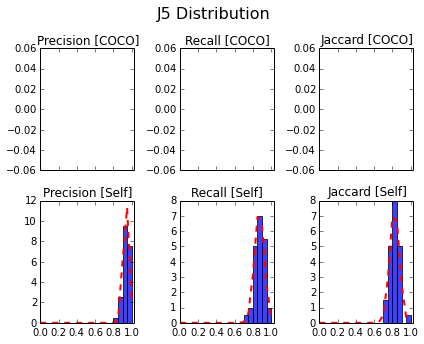

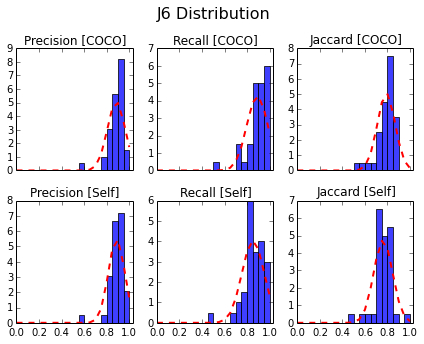

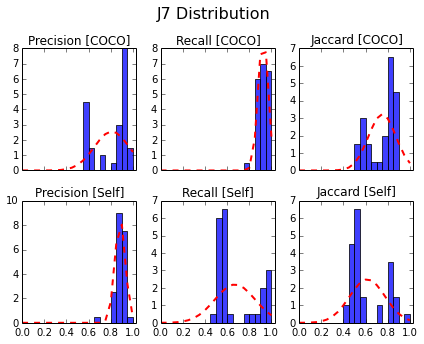

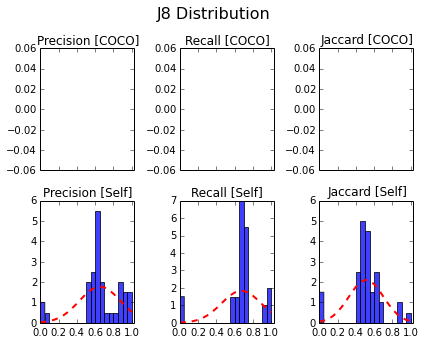

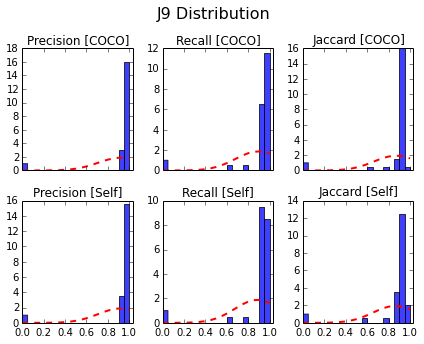

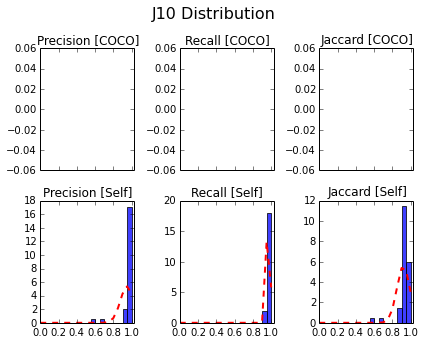

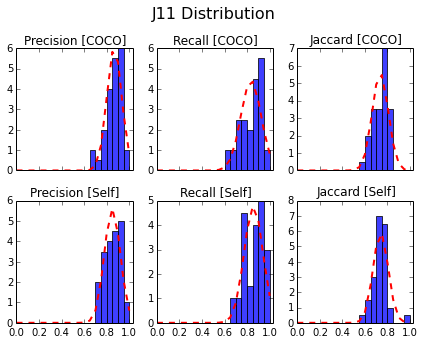

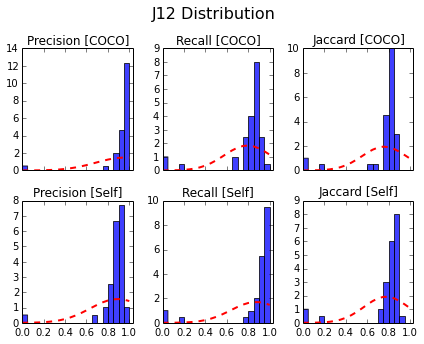

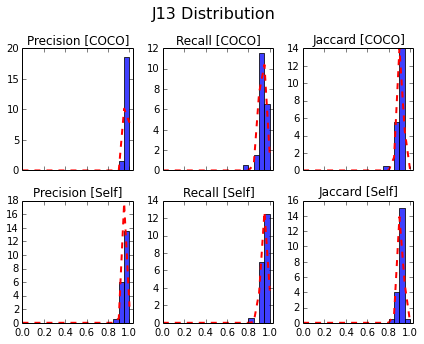

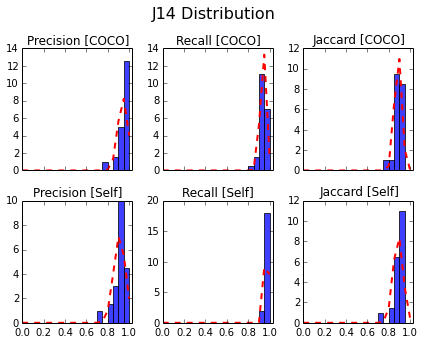

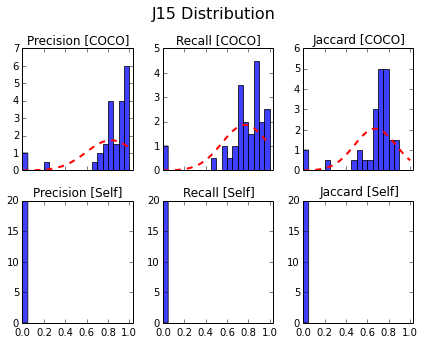

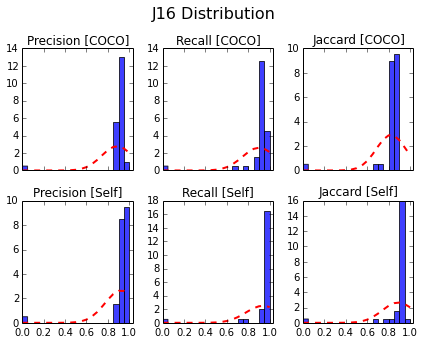

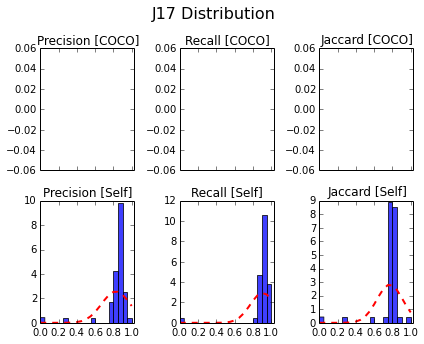

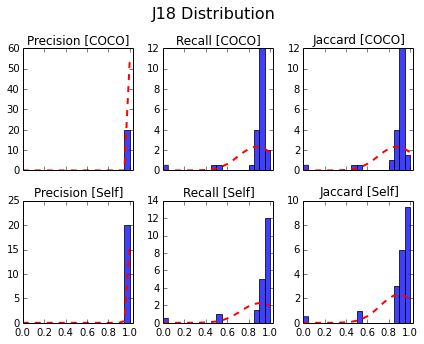

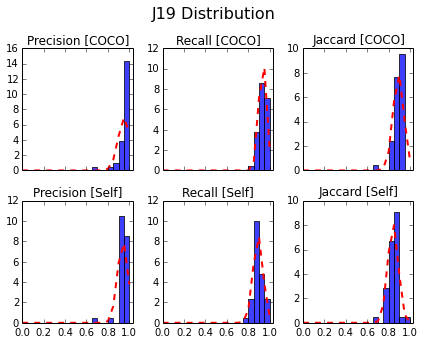

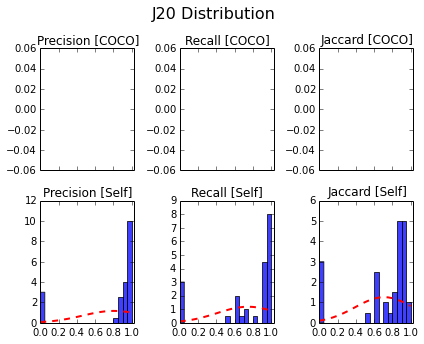

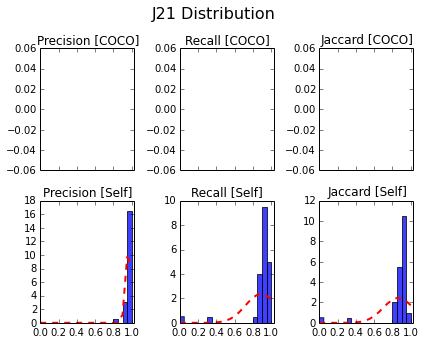

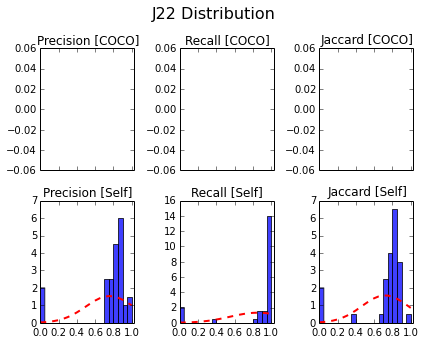

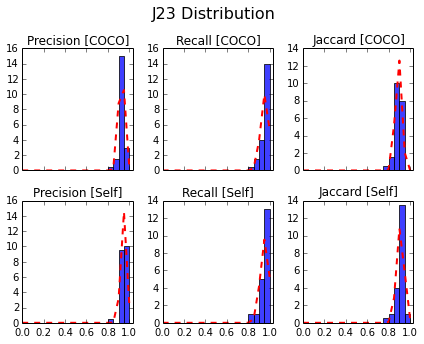

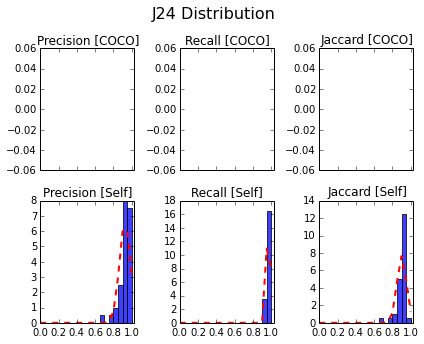

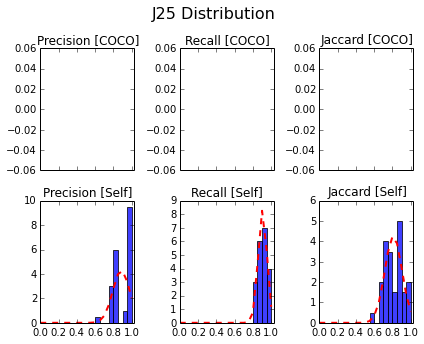

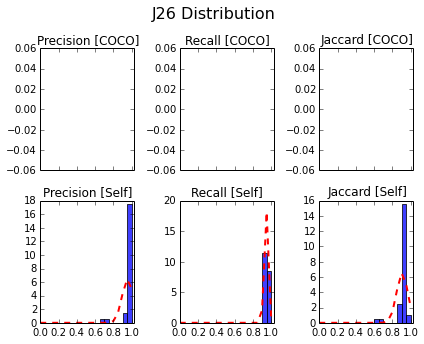

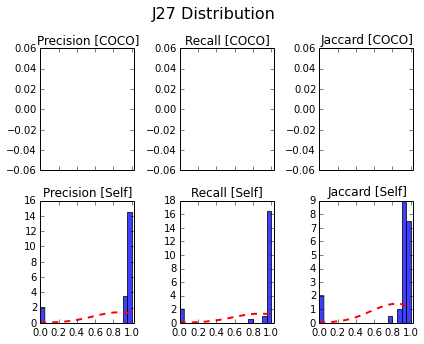

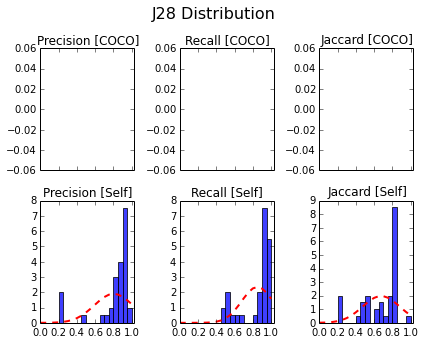

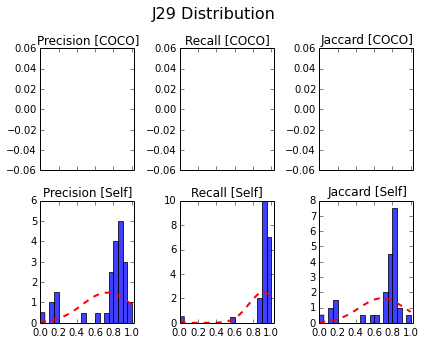

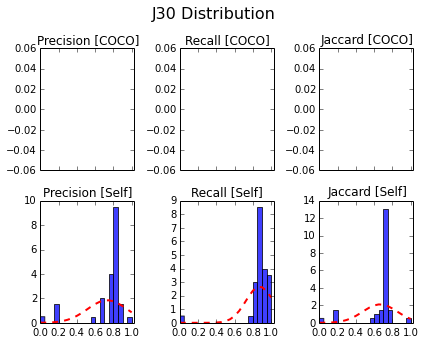

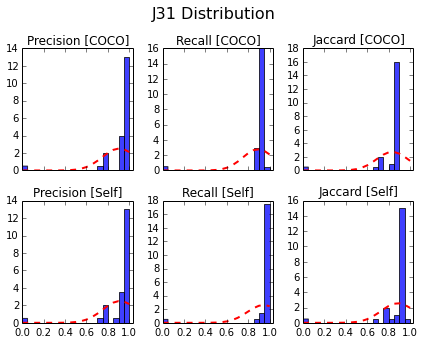

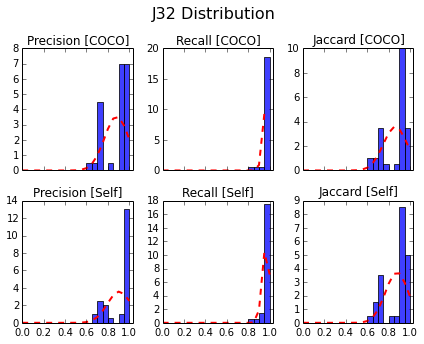

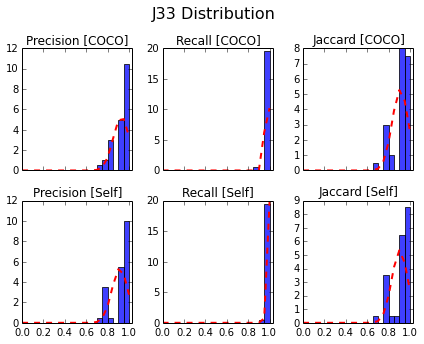

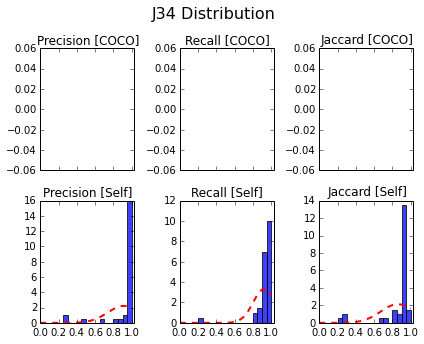

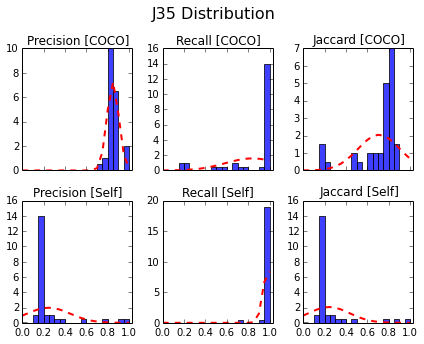

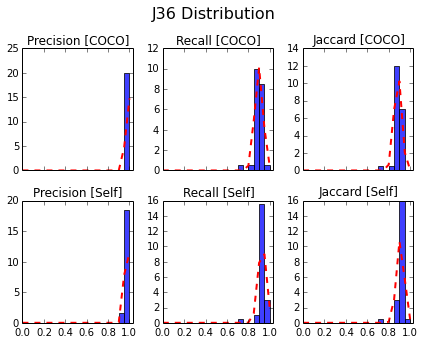

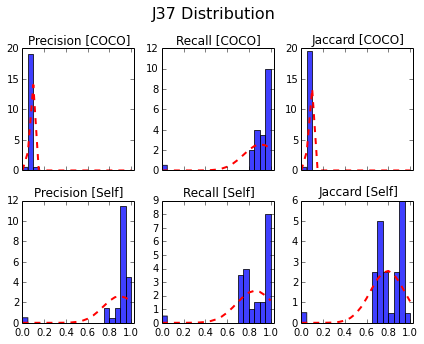

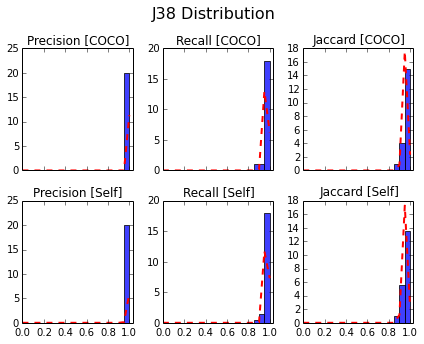

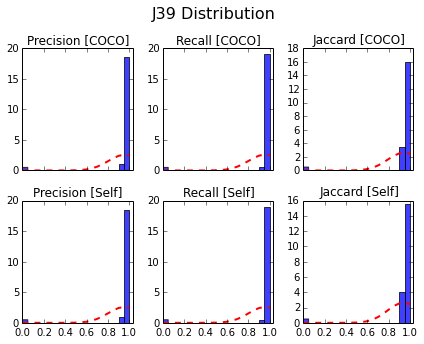

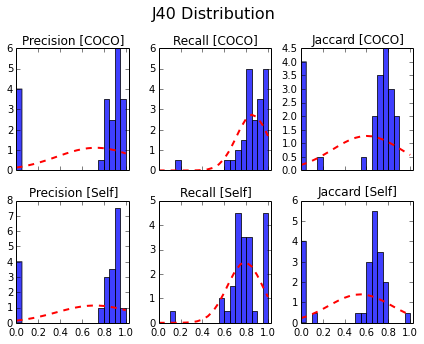

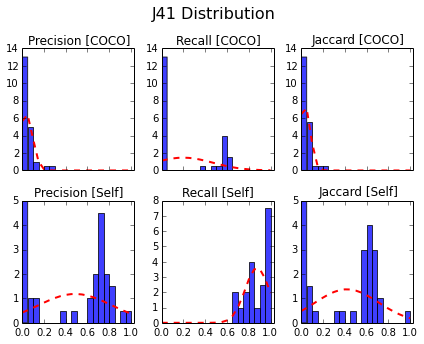

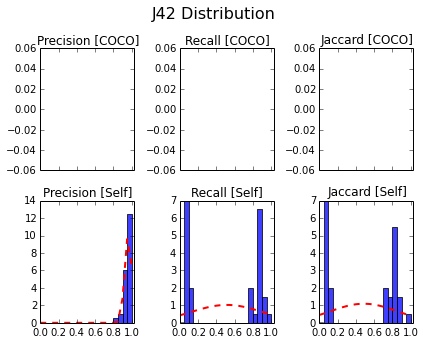

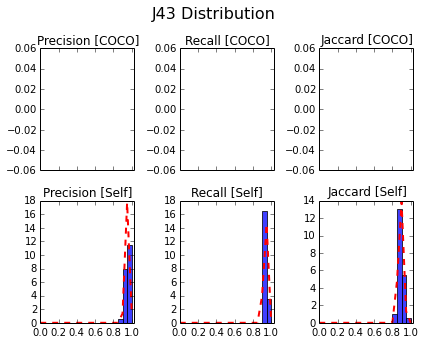

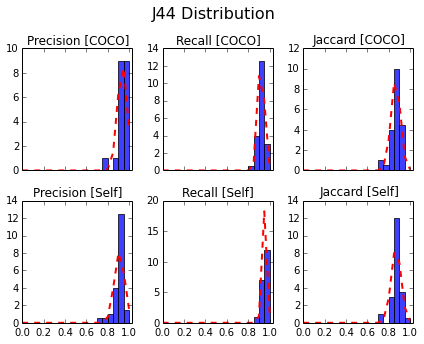

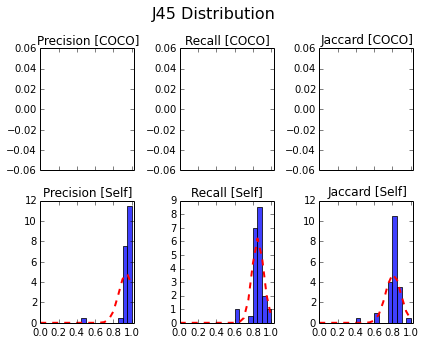

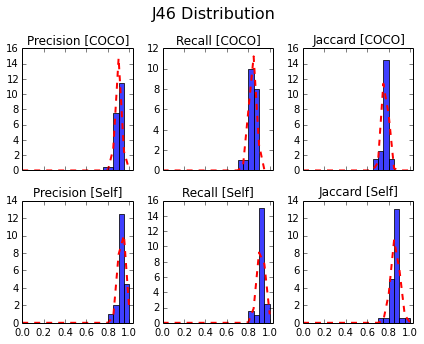

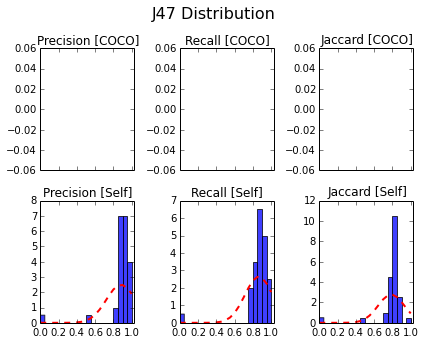

In [158]:
bin_size = 20
fcn  = stats.norm
SHOW_PLOT=True
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW
data_fit_stats=[]
for objid in object_id_lst:
    if SHOW_PLOT:
        fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
        stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
        axs = axs.ravel()
    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_info  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
    
    numPoints = bb_info["x_locs"].apply(lambda x: len(ast.literal_eval(x))).mean()
    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
#         table_data.append(basic_stat(metric_value,metric))
        metric_value = np.array(bb_info[metric])#[bb_info[metric]>0][bb_info[metric]<=1]) 
#         print metric_value
        if len(metric_value)!=0:            
            params = fcn.fit(metric_value)
            histo,bin_edges = np.histogram(metric_value, bin_size, normed=1)
            bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
            y = fcn.pdf(bins, *params)
            RSS =sum((histo-y)**2)
            ks_result = kolmogorov_smirnov(bins,y,"J"+str(objid)+metric) #D-value and p-value
            # object_id, Metric, mu, sd,RSS,D-value,p-value,numPoints
            data_stats  = [objid,metric,params[0],params[1],RSS,ks_result[1],ks_result[0],numPoints] 
            #same as what you would get if you did basic_stats because in the MLE estimate, mu and sigma is equal to sample mean and sample sd
            data_fit_stats.append(data_stats)
            if SHOW_PLOT:
                ax = axs[i]
                ax.set_title(metric)
                #ax.hist(metric_value,bins=30)
                ax.set_xlim(0,1.03)
                n, bins, patches = ax.hist(metric_value, bin_size, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
                y = fcn.pdf(bins, *params)
                l = ax.plot(bins, y, 'r--', linewidth=2) 
        else:
            #Inexact COCO matches, metric flagged as -1 
            pass

    if SHOW_PLOT: fig.tight_layout()
# fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

In [159]:
gaussian_fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Mean", "SD","RSS","D-value","p-value","Average Num Point"])

In [160]:
gaussian_fit_results.groupby("Metric").count()

,object_id,Mean,SD,RSS,D-value,p-value,Average Num Point
Metric,,,,,,,
Jaccard [COCO],47,47,47,25,47,47,47
Jaccard [Self],47,47,47,46,47,47,47
Precision [COCO],47,47,47,25,47,47,47
Precision [Self],47,47,47,46,47,47,47
Recall [COCO],47,47,47,25,47,47,47
Recall [Self],47,47,47,46,47,47,47


now we've incorporated more of the [Self]  entries 

In [252]:
#The fitting is not really statistically significant, average RSS is quite large too 
print gaussian_fit_results.RSS.mean()
print len(gaussian_fit_results[gaussian_fit_results["p-value"]>0.5])/float(len(gaussian_fit_results)),"% is statistically significantly Gaussian"
print len(gaussian_fit_results)

746.916411489
0.645390070922 % is statistically significantly Gaussian
282


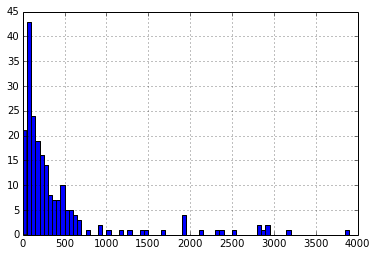

In [162]:
gaussian_fit_results.RSS.hist(bins=100,range=(0,5000))

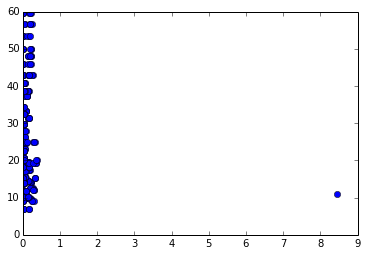

In [170]:
plt.plot(gaussian_fit_results["SD"],gaussian_fit_results["Average Num Point"],'o')

In [167]:
metrics = list(set(gaussian_fit_results["Metric"]))

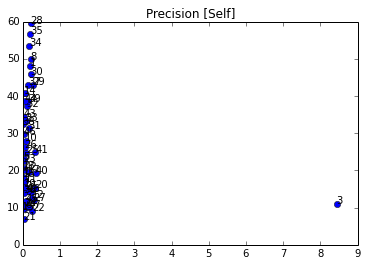

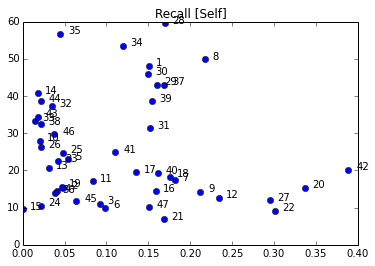

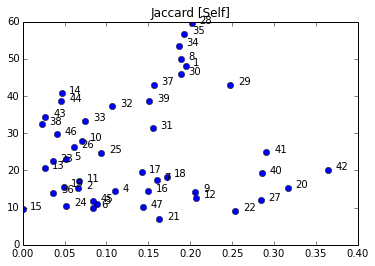

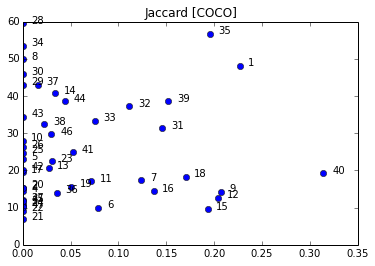

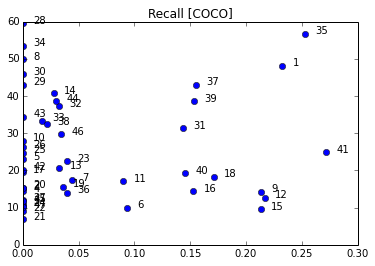

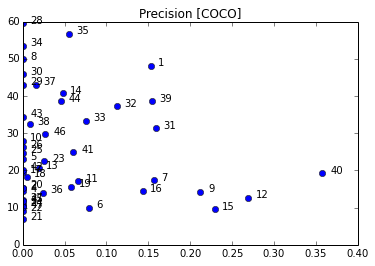

In [168]:
for metric in metrics:
    plt.figure()
    plt.title(metric)
    metric_only_fit_result = gaussian_fit_results[gaussian_fit_results["Metric"]==metric]
    plt.plot(metric_only_fit_result["SD"],metric_only_fit_result["Average Num Point"],'o')
    for row in metric_only_fit_result.iterrows():
        row = row[1]
        plt.text(row["SD"]+0.01,row["Average Num Point"]+0.01,str(row["object_id"]))

Outliers: 
- 3 chocolate : there is quite a few imprecise BB drawn. 
- 12 knife, very narrow object, hard to annotate
- 15 car, also a small object, hard to annotate
- 9 book, several disagreements
- 40 driver (small,hard to annotate) 
- 41 yellow bannana (task ambiguity)
- 18 monitor, although this is quite a rectangular looking object, there is also quite a few disagreement in the border regions

Filtering out the task ambiguity outliers: 

In [213]:
task_ambiguous_outlier =[2,3,8,12,15,18,40,41,42]

In [232]:
R_coefficient_results=[]

R: 0.191906505069
p-value:  0.248401625757
R: -0.168794006456
p-value:  0.311036292457
R: 0.108423433132
p-value:  0.51701437016
R: 0.200273242947
p-value:  0.22797687494
R: 0.253579253663
p-value:  0.124493888408
R: 0.0445593651973
p-value:  0.790517659247


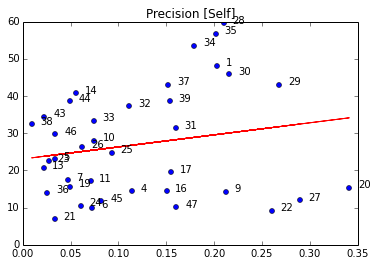

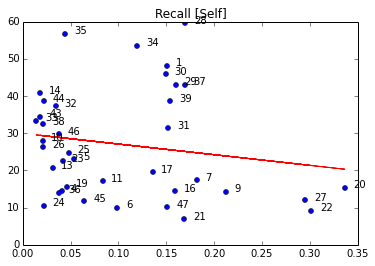

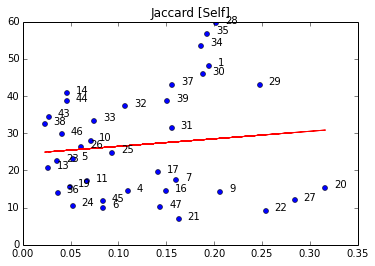

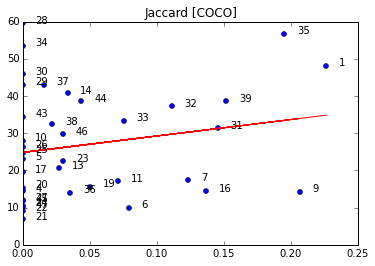

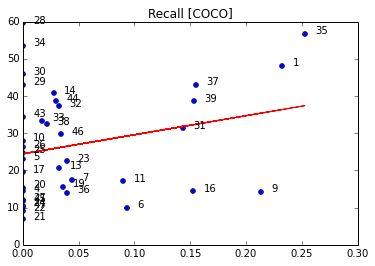

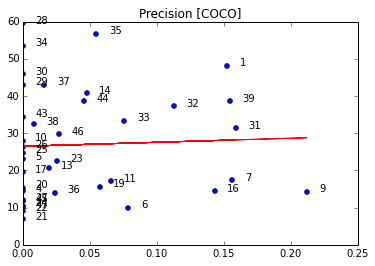

In [234]:
R_coeff = ['Average Num Point']
for metric in metrics:
    plt.figure()
    plt.title(metric)
    metric_only_fit_result = gaussian_fit_results[gaussian_fit_results["Metric"]==metric][~gaussian_fit_results["object_id"].isin(task_ambiguous_outlier)]
    for row in metric_only_fit_result.iterrows():
        row = row[1]
#         if row["object_id"] not in task_ambiguous_outlier:
        x=  row["SD"]
        y = row["Average Num Point"]

        plt.text(x+0.01,y+0.01,str(row["object_id"]))
    xdata = metric_only_fit_result["SD"]
    ydata = metric_only_fit_result["Average Num Point"]
    plt.plot(xdata,ydata,'o',color="blue",ms=5)            
    params = np.polyfit(xdata,ydata,1)
    fcn = np.poly1d(params)
    y_interpolate = fcn(xdata)
    plt.plot(xdata,y_interpolate,'red')
    results =stats.pearsonr(xdata,ydata)
    print "R:",results[0]
    print "p-value: ",results[1]
    R_coeff.append(results[0])
R_coefficient_results.append(R_coeff)

Using the average number of bounding points per object from the worker annotation might not be a good measure, maybe its better to just look at boundary points from the ground truths 

In [228]:
bbg = pd.read_csv("my_ground_truth.csv")

R: 0.0253289095173
p-value:  0.880018196752
R: -0.18461743256
p-value:  0.267165890181
R: -0.0283783372385
p-value:  0.865697551591
R: -0.0676885698663
p-value:  0.686370527355
R: 0.0154859278499
p-value:  0.926477021474
R: -0.0691152194754
p-value:  0.680107746688


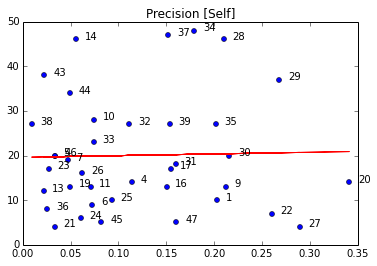

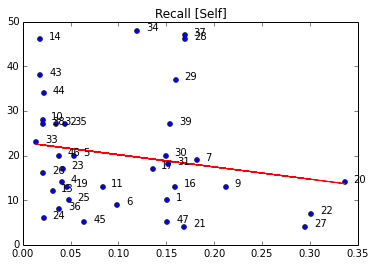

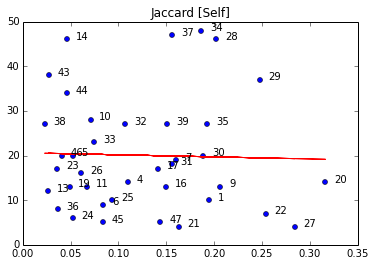

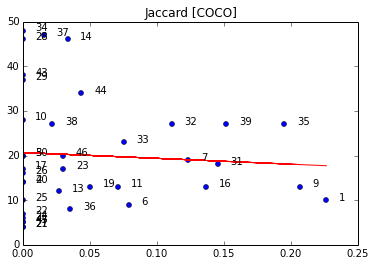

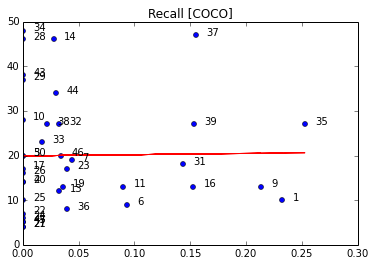

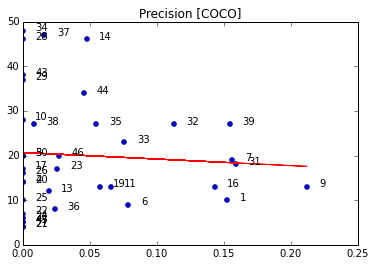

In [235]:
R_coeff=['Self Ground Truth Num Points']
for metric in metrics:
    plt.figure()
    plt.title(metric)
    metric_only_fit_result = gaussian_fit_results[gaussian_fit_results["Metric"]==metric][~gaussian_fit_results["object_id"].isin(task_ambiguous_outlier)]
    ydata = []
    for row in metric_only_fit_result.iterrows():
        row = row[1]
#         if row["object_id"] not in task_ambiguous_outlier:
        x=  row["SD"]
        #y = row["Average Num Point"]
        bbg_obj = bbg[bbg["object_id"]==row["object_id"]]
        numPoints = bbg_obj["x_locs"].apply(lambda x: len(ast.literal_eval(x))).mean()
        ydata.append(numPoints)
        plt.text(x+0.01,numPoints+0.01,str(row["object_id"]))
    xdata = metric_only_fit_result["SD"]
    #ydata = metric_only_fit_result["Average Num Point"]
    plt.plot(xdata,ydata,'o',color="blue",ms=5)            
    params = np.polyfit(xdata,ydata,1)
    fcn = np.poly1d(params)
    y_interpolate = fcn(xdata)
    plt.plot(xdata,y_interpolate,'red')
    results =stats.pearsonr(xdata,ydata)
    print "R:",results[0]
    print "p-value: ",results[1]
    R_coeff.append(results[0])
R_coefficient_results.append(R_coeff)

we could quantify these further using boundary complexity with measures such as fractal dimension index...etc but I don't think there is a correlation. 
https://github.com/pondrejk/PolygonComplexity

In [242]:
metrics_lst

['Precision [COCO]',
 'Recall [COCO]',
 'Jaccard [COCO]',
 'Precision [Self]',
 'Recall [Self]',
 'Jaccard [Self]']

['P[C]', 'R[C]', 'J[C]', 'P[S]', 'R[S]', 'J[S]']

In [243]:
tabulate?

In [247]:
from tabulate import tabulate 
print tabulate(R_coefficient_results,headers=['P[C]','R[C]','J[C]','P[S]','R[S]','J[S]'],tablefmt='latex',showindex=False,floatfmt=".2f")

\begin{tabular}{lrrrrrr}
\hline
                              &   P[C] &   R[C] &   J[C] &   P[S] &   R[S] &   J[S] \\
\hline
 Average Num Point            &   0.19 &  -0.17 &   0.11 &   0.20 &   0.25 &   0.04 \\
 Self Ground Truth Num Points &   0.03 &  -0.18 &  -0.03 &  -0.07 &   0.02 &  -0.07 \\
\hline
\end{tabular}
